In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split

In [3]:
train_dir_path = '/kaggle/input/fer2013/train/'
test_dir_path = '/kaggle/input/fer2013/test/'
def Classes_Count(path, name):
    Classes_Dict = {}
    for Class in os.listdir(path):
        Full_Path = os.path.join(path, Class)
        if Class in ["happy", "sad"]:
            Classes_Dict[Class] = len(os.listdir(Full_Path))
    df = pd.DataFrame(Classes_Dict, index=[name]).transpose()
    return df
Train_Count = Classes_Count(train_dir_path, 'Train')
Test_Count = Classes_Count(test_dir_path, 'Test')
print(f"Train Count= \n{Train_Count} \n Test Count= \n{Test_Count}")


Train Count= 
       Train
sad     4830
happy   7215 
 Test Count= 
       Test
sad    1247
happy  1774


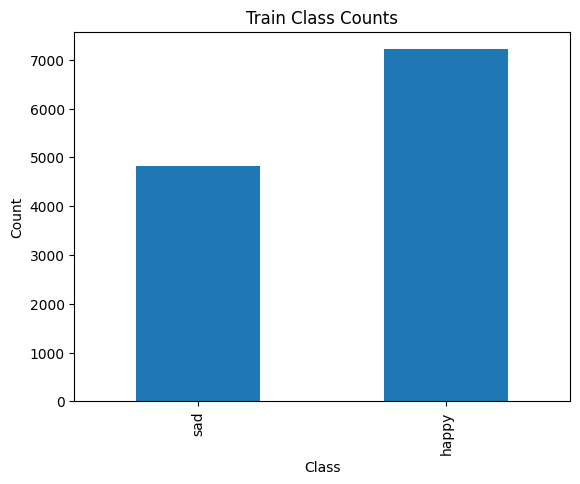

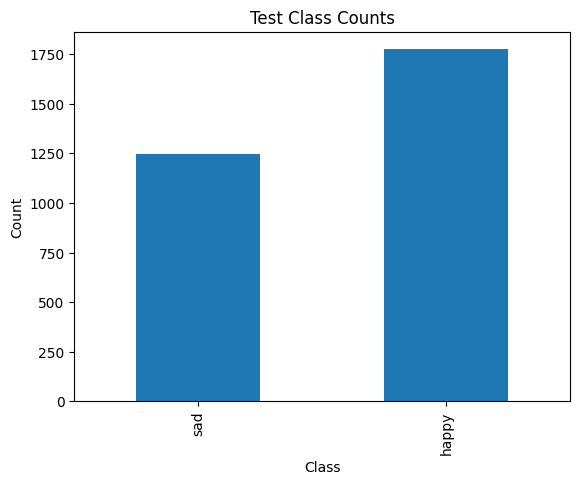

In [4]:
Train_Count.plot(kind='bar', legend=False)
plt.title('Train Class Counts')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()
Test_Count.plot(kind='bar', legend=False)
plt.title('Test Class Counts')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [5]:
train_files = []
train_labels = []
test_files = []
test_labels = []
target_classes = ["happy", "sad"]
def filter_classes(class_name):
    return class_name in target_classes
for class_name in filter(filter_classes, os.listdir(train_dir_path)):
    class_path = os.path.join(train_dir_path, class_name)
    for file_name in os.listdir(class_path):
        file_path = os.path.join(class_path, file_name)
        train_files.append(file_path)
        train_labels.append(class_name)
for class_name in filter(filter_classes, os.listdir(test_dir_path)):
    class_path = os.path.join(test_dir_path, class_name)
    for file_name in os.listdir(class_path):
        file_path = os.path.join(class_path, file_name)
        test_files.append(file_path)
        test_labels.append(class_name)
train_df = pd.DataFrame({'File': train_files, 'Label': train_labels})
test_df = pd.DataFrame({'File': test_files, 'Label': test_labels})
print(f"Train Data: {train_df.head()}")
print(f"\nTest Data: {test_df.head()}")

Train Data:                                                 File Label
0  /kaggle/input/fer2013/train/sad/Training_89959...   sad
1  /kaggle/input/fer2013/train/sad/Training_20087...   sad
2  /kaggle/input/fer2013/train/sad/Training_13633...   sad
3  /kaggle/input/fer2013/train/sad/Training_87971...   sad
4  /kaggle/input/fer2013/train/sad/Training_41661...   sad

Test Data:                                                 File Label
0  /kaggle/input/fer2013/test/sad/PublicTest_5086...   sad
1  /kaggle/input/fer2013/test/sad/PublicTest_4475...   sad
2  /kaggle/input/fer2013/test/sad/PrivateTest_331...   sad
3  /kaggle/input/fer2013/test/sad/PublicTest_3868...   sad
4  /kaggle/input/fer2013/test/sad/PrivateTest_572...   sad


In [6]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
filtered_train_labels = list(filter(lambda x: x in ["happy", "sad"], train_labels))
filtered_test_labels = list(filter(lambda x: x in ["happy", "sad"], test_labels))
train_labels_encoded = label_encoder.fit_transform(filtered_train_labels)
test_labels_encoded = label_encoder.transform(filtered_test_labels)
print(f"ENCODED TRAIN LABELS = {train_labels_encoded}")
print(f"ENCODED TEST LABELS = {test_labels_encoded}")
y_train_categorical = tf.keras.utils.to_categorical(train_labels_encoded)
y_test_categorical = tf.keras.utils.to_categorical(test_labels_encoded)

ENCODED TRAIN LABELS = [1 1 1 ... 0 0 0]
ENCODED TEST LABELS = [1 1 1 ... 0 0 0]


In [7]:
import cv2
example_image_path = train_df[train_df['Label'].isin(["happy", "sad"])]['File'].iloc[0]
image_shape = cv2.imread(example_image_path).shape
print(image_shape)

(48, 48, 3)


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['Label'])

datagen = ImageDataGenerator(rescale=1.0/255.0)
batch_size = 64
train_data = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='File',
    y_col='Label',
    target_size=(image_shape[0], image_shape[1]),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)
test_data = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='File',
    y_col='Label',
    target_size=(image_shape[0], image_shape[1]),
    batch_size=batch_size,
#     class_mode='categorical',
    class_mode='categorical',
    shuffle=False
)
val_data = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='File',
    y_col='Label',
    target_size=(image_shape[0], image_shape[1]),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Found 9636 validated image filenames belonging to 2 classes.
Found 3021 validated image filenames belonging to 2 classes.
Found 2409 validated image filenames belonging to 2 classes.


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build the CNN model
model = Sequential()

# Convolutional layer 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_shape[0], image_shape[1], 3)))
model.add(MaxPooling2D(2, 2))

# Convolutional layer 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

# Convolutional layer 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

# Flatten the output and feed it into dense layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(2, activation = 'softmax')) #activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 128)         0

In [10]:
# history = model.fit(train_data, epochs=10, validation_data=test_data)
history = model.fit(train_data, epochs=10, validation_data=val_data)


Epoch 1/10
151/151 [==============================] - 77s 457ms/step - loss: 0.6102 - accuracy: 0.6542 - val_loss: 0.4895 - val_accuracy: 0.7650
Epoch 2/10
151/151 [==============================] - 11s 74ms/step - loss: 0.4468 - accuracy: 0.7841 - val_loss: 0.4388 - val_accuracy: 0.8099
Epoch 3/10
151/151 [==============================] - 12s 77ms/step - loss: 0.4047 - accuracy: 0.8186 - val_loss: 0.4510 - val_accuracy: 0.8194
Epoch 4/10
151/151 [==============================] - 11s 76ms/step - loss: 0.4276 - accuracy: 0.8218 - val_loss: 0.9083 - val_accuracy: 0.8016
Epoch 5/10
151/151 [==============================] - 11s 74ms/step - loss: 0.3474 - accuracy: 0.8442 - val_loss: 0.5328 - val_accuracy: 0.8356
Epoch 6/10
151/151 [==============================] - 12s 77ms/step - loss: 0.3032 - accuracy: 0.8670 - val_loss: 0.4924 - val_accuracy: 0.8510
Epoch 7/10
151/151 [==============================] - 12s 80ms/step - loss: 0.2763 - accuracy: 0.8789 - val_loss: 0.5431 - val_accuracy

In [11]:
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc}")

48/48 [==============================] - 16s 340ms/step - loss: 0.3716 - accuracy: 0.8434
Test Accuracy: 0.8434293270111084


In [12]:
predictions = model.predict(test_data)
binary_predictions = (predictions > 0.5).astype(int)
binary_predictions

48/48 [==============================] - 3s 57ms/step


array([[1, 0],
       [0, 1],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

1/1 [==============================] - 0s 19ms/step


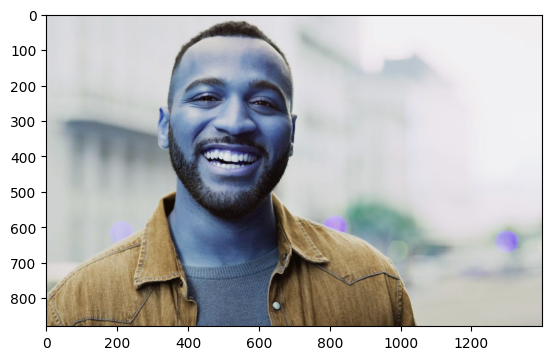

1.0
Sentiment: Happy


In [15]:
import cv2
import numpy as np

# Function to load and preprocess the image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (image_shape[0], image_shape[1]))
    image = image.astype('float32') / 255.0
    return image

# Path to the new image
image_path = "/kaggle/input/personal/happy.jpg"# Replace with the actual image filename
# Load and preprocess the image
image = preprocess_image(image_path)

# Reshape the image to match the input shape of the model
image = np.expand_dims(image, axis=0)

# Perform sentiment prediction on the image
prediction = model.predict(image)

# Get the sentiment label
sentiment_label = 'Happy' if prediction[0][0] > 0.5 else 'Sad'
img = cv2.imread(image_path)
plt.imshow(img)
plt.show()
# Print the prediction
print(prediction[0][0])
print("Sentiment:", sentiment_label)